In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.special import expi, betainc, beta, erf
from scipy.optimize import curve_fit
from numba import njit, jit
font = {'size': 25, 'weight':'normal'}
plt.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
rng = np.random.default_rng(seed=42)
colors=[['blue',"slateblue"], ['darkgoldenrod', "goldenrod"], ['red', "indianred",], ['olivedrab', "yellowgreen"], ['black','dimgray'], ['plum',"pink"],['orangered','coral'] ]

from numba import jit
from collections import defaultdict
from numba.typed import Dict,List
from numba import types
from matplotlib.ticker import LogLocator, NullFormatter


We estimate $\pi_n$ from the mean of $F_n$ in the following way. If $\pi_n \propto n^{-\alpha}$, we use that $\frac{\int_{b^i}^{b^{i+1}} \pi_n dn}{b^i} = \frac{F_{b^{i+1}} - F_{b^i}}{b^i} = \frac{1}{b^{i \alpha}}\left(1-\frac{1}{b^\alpha} \right)$, so that plotting $\log  \frac{F_{b^{i+1}} - F_{b^i}}{b^i}$ against $\log (b^i)$ gives a slope $\alpha$.

# 2D Case

In [98]:
Nsamples = 1500
Nvisits = 1500000
dir_array = np.array([[-1,0],[1,0],[0,1],[0,-1]])

@jit(nopython=True)
def flip_list_sample_origin():
    # here a flip happens when the RW goes from incrementing the span to the origin of the walk
    # returns an array flip_array of size Nvisits / sample_flip_gap 
    # flip[k] is 1 if there has been a flip at the sample_flip_gap * k visit, 0 else
    food_eaten = 1
    c0 = (0,0)
    c=c0
    pos={}
    pos[c]=True

    last_color_eaten = 1 # -1 = origin, 1 = boundary (positive >0 abscissa)
    flip_array = np.zeros(Nvisits) # flip_array[k] is 0 if no flip at the kth visit, 1 else
    while food_eaten <= Nvisits-1:
        v = dir_array[np.random.randint(0,4)]
        c=(c[0]+v[0],c[1]+v[1])
        is_c_0 = (c==c0)


        if c not in pos:
            pos[c]=True
            # flip_array[food_eaten]=int(last_color_eaten==-1)
            food_eaten+=1
            last_color_eaten=1
            
        elif last_color_eaten==1 and is_c_0:
            flip_array[food_eaten]=1
            last_color_eaten=-1
            # food_eaten+=1 don't do it... useless and not what we want

    # print(nb_origin)
    return flip_array





In [59]:
f = []
for s in range(Nsamples):
    f.append(flip_list_sample_origin())
    print(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
f_mean = np.mean(f, axis=0)
mean_F = np.cumsum(f_mean)
np.save("./mean_F.npy",mean_F)

C:\Users\julie\AppData\Local\Temp\ipykernel_932\3746183662.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.plot(t_logscale*np.log(t_logscale), .7/ (t_logscale*np.log(t_logscale)),'--k',linewidth=2.5)
C:\Users\julie\AppData\Local\Temp\ipykernel_932\3746183662.py:26: RuntimeWarning: divide by zero encountered in log
  plt.plot(t_logscale*np.log(t_logscale), 0.5 / (np.sqrt(np.log(t_logscale))*t_logscale*np.log(np.log(t_logscale))),'--',color='red')
C:\Users\julie\AppData\Local\Temp\ipykernel_932\3746183662.py:26: RuntimeWarning: invalid value encountered in multiply
  plt.plot(t_logscale*np.log(t_logscale), 0.5 / (np.sqrt(np.log(t_logscale))*t_logscale*np.log(np.log(t_logscale))),'--',color='red')


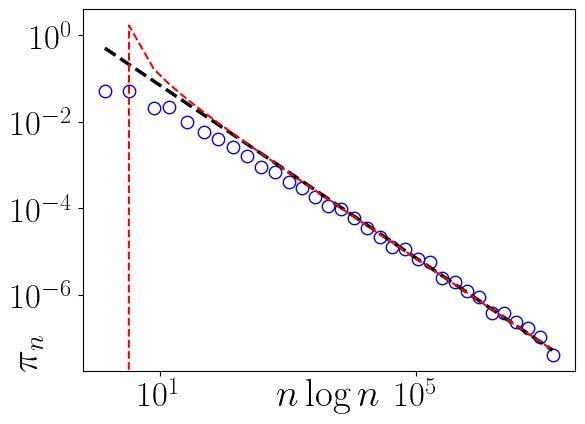

In [95]:

mean_F = np.load("./mean_F.npy")
base=1.5
Nvisits=mean_F.size
t_logscale = np.array([int(base**i) for i in range(0,int(np.emath.logn(base,Nvisits)))])
pi_coarsegrained = np.array([(mean_F[int(base**(i+1))]-mean_F[int(base**i)])/(int(base**(i))) for i in range(0,int(np.emath.logn(base,Nvisits)))])
fig, ax = plt.subplots(1, 1)
# it is closer to 1/n log log n, but I dont know how to prove it.
plt.scatter(
    t_logscale*np.log(t_logscale),
    pi_coarsegrained,
    color='blue',           # Edge color
    s=80,                    # Marker size (7^2)
    facecolors='white',      # Hollow markers
    linewidths=1             # Edge line width
)

# plt.plot(t_logscale*np.log(np.log(8*t_logscale)), .5/ (t_logscale*np.log(8*t_logscale)),'--',color='green',linewidth=2.5)

# plt.plot(t_logscale*np.log(np.log(8*t_logscale)), .5/ (t_logscale*np.log(8*t_logscale)*np.sqrt(t_logscale)),'--',color='green',linewidth=2.5)

# plt.plot(t_logscale * np.log(t_logscale), .17/ (t_logscale*np.log(np.log(8*t_logscale))),'--k',linewidth=2.5) # works very well.

# plt.plot(t_logscale*np.log(np.log(8*t_logscale)), .17/ (t_logscale*np.log(np.log(8*t_logscale))),'--k',linewidth=2.5) 
plt.plot(t_logscale*np.log(t_logscale), .7/ (t_logscale*np.log(t_logscale)),'--k',linewidth=2.5) 

plt.plot(t_logscale*np.log(t_logscale), 0.5 / (np.sqrt(np.log(t_logscale))*t_logscale*np.log(np.log(t_logscale))),'--',color='red')
plt.semilogx()
plt.semilogy()

ax.set_xticks([10, 1e5])

ax.set_ylabel(r'$\pi_n$', fontsize=28, labelpad=-25,loc='bottom')
ax.set_xlabel(r'$n \log n$', fontsize=28, labelpad=-25,loc='center')
plt.tight_layout()
# plt.savefig('./Figures/pin-2d.pdf', dpi=600, bbox_inches='tight')
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_932\2466628268.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, (mean_F) /((np.log(np.log(times)))))
C:\Users\julie\AppData\Local\Temp\ipykernel_932\2466628268.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, (mean_F) / (np.log(times)/np.log(np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_932\2466628268.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(times, (mean_F) / (np.log(times)/np.log(np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_932\2466628268.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, (mean_F) / (np.sqrt(np.log(times))/np.log(np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_932\2466628268.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(times, (mean_F) / (np.sqrt(np.log(times))/np.log(np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_932\2466628268.py:9: RuntimeWarn

[        nan -0.          0.02265706 ...  0.57371829  0.57371828
  0.57371826]


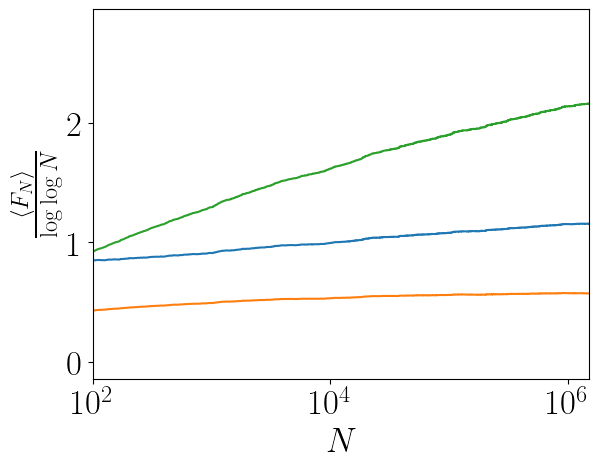

In [17]:
times = np.arange(1,Nvisits+1)

fig, ax = plt.subplots(1,1)
plt.plot(times, (mean_F) /((np.log(np.log(times)))))

plt.plot(times, (mean_F) / (np.log(times)/np.log(np.log(times))))

plt.plot(times, (mean_F) / (np.sqrt(np.log(times))/np.log(np.log(times))))
print((mean_F) / (np.log(times)/np.log(np.log(times))))
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\frac{\langle F_N \rangle}{\log \log N}$")
plt.xlim(100,times[-1])
plt.semilogx()

# plt.xlim(-2.5,4)
# plt.savefig(f"Figures/mean-nb-flips-boundary-to-origin-2d.pdf", dpi=600,bbox_inches='tight')
plt.show()

## Analysis of the typical radius at which the nth site is discovered

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from math import sqrt, floor, log2

# Parameters
num_walks = 2000000
n_target = 1000
L = n_target//2  # Half-size of grid
origin = (L, L)  # shift origin to center of the grid
dirs = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])

@njit
def simulate_walk(n_target, L, dirs):
    radii = []
    food_eaten = 1
    c0 = (0,0)
    c=c0
    pos={}
    pos[c]=True

    last_color_eaten = 1 # -1 = origin, 1 = boundary (positive >0 abscissa)
    flip_array = np.zeros(n_target) # flip_array[k] is 0 if no flip at the kth visit, 1 else
    while food_eaten <= n_target-1:
        v = dir_array[np.random.randint(0,4)]
        c=(c[0]+v[0],c[1]+v[1])
        is_c_0 = (c==c0)


        if c not in pos:
            pos[c]=True
            # flip_array[food_eaten]=int(last_color_eaten==-1)
            food_eaten+=1
            last_color_eaten=1
            radii.append((np.sqrt(c[0]**2+c[1]**2), food_eaten))
            
        elif last_color_eaten==1 and is_c_0:
            flip_array[food_eaten]=1
            last_color_eaten=-1
            # radii.append((np.sqrt(c[0]**2+c[1]**2), food_eaten))
            
    return radii

r_values = np.zeros(n_target)
# Run simulation
for i in range(num_walks):
    if i % 10000 == 0:
        print(f"Simulation {i}")
    result = simulate_walk(n_target, L, dirs)
    print(len(result))
    for (r,n) in result:
        r_values[n] 

Simulation 0
999


IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [65]:
np.save(f"./rn_n{n_target}.npy",r_values)

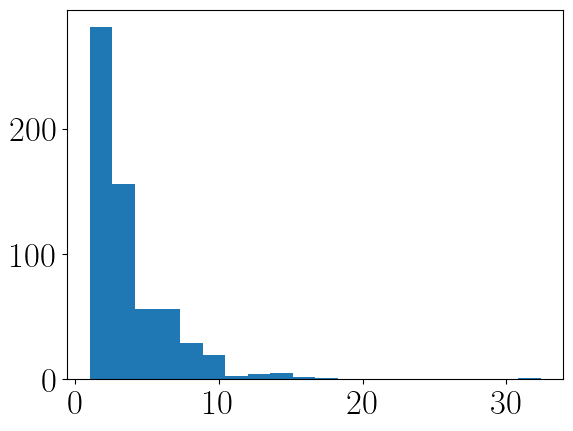

In [61]:
r_values = np.array(r_values)
plt.hist(r_values,bins=20)
plt.show()

In [64]:
np.mean(r_values) / np.log(n_target)
np.mean(r_values) / np.sqrt(np.log(n_target))

1.4033659197840698

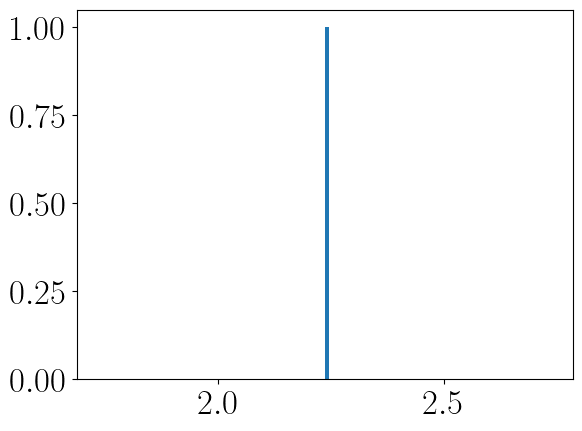

In [31]:
plt.hist(r_values,bins=100)
plt.show()

# 3D case

In [42]:
Nsamples = 300000
Nvisits = 3000
dir_array = np.array([[-1,0,0],[1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]])

@jit(nopython=True)
def flip_list_sample_origin():
    # here a flip happens when the RW goes from incrementing the span to the origin of the walk
    # returns an array flip_array of size Nvisits / sample_flip_gap 
    # flip[k] is 1 if there has been a flip at the sample_flip_gap * k visit, 0 else
    food_eaten = 1
    c0 = (0,0,0)
    c=c0
    pos={}
    pos[c]=True

    last_color_eaten = 1 # -1 = origin, 1 = boundary (positive >0 abscissa)
    flip_array = np.zeros(Nvisits) # flip_array[k] is 0 if no flip at the kth visit, 1 else
    while food_eaten <= Nvisits-1:
        v = dir_array[np.random.randint(0,6)]
        c=(c[0]+v[0],c[1]+v[1],c[2]+v[2])
        is_c_0 = (c==c0)

        if c not in pos:
            pos[c]=True
            # flip_array[food_eaten]=int(last_color_eaten==-1)
            food_eaten+=1
            last_color_eaten=1
            
        elif last_color_eaten==1 and is_c_0:
            flip_array[food_eaten]=1
            last_color_eaten=-1
            # food_eaten+=1 don't do it... useless and not what we want

        
    # print(nb_origin)
    return flip_array

In [43]:
f = []
for s in range(Nsamples):
    f.append(flip_list_sample_origin())
    if s%1000==0:
        print(s)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [44]:
f_mean = np.mean(f, axis=0)
mean_F = np.cumsum(f_mean)
np.save("./mean_F_3d.npy",mean_F)

C:\Users\julie\AppData\Local\Temp\ipykernel_10116\2250689914.py:18: RuntimeWarning: divide by zero encountered in log
  print(np.polyfit(np.log(t_logscale),np.log(pi_coarsegrained),1))


[nan nan]


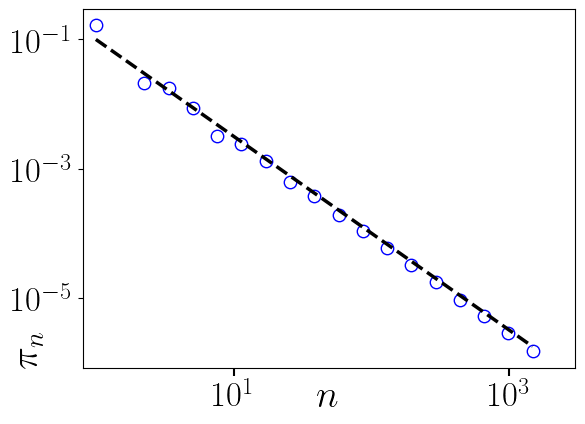

In [10]:

mean_F = np.load("./mean_F_3d.npy")
Nvisits=mean_F.size
mu = 3/2
base=1.5
t_logscale = np.array([base**i for i in range(0,int(np.emath.logn(base,Nvisits)))])
pi_coarsegrained = np.array([(mean_F[np.rint(base**(i+1)).astype(int)]-mean_F[np.rint(base**i).astype(int)])/(base**(i)) for i in range(0,int(np.emath.logn(base,Nvisits)))])

fig, ax = plt.subplots(1, 1)
plt.scatter(
    t_logscale,
    pi_coarsegrained,
    color='blue',           # Edge color
    s=80,                    # Marker size (7^2)
    facecolors='white',      # Hollow markers
    linewidths=1             # Edge line width
)

print(np.polyfit(np.log(t_logscale),np.log(pi_coarsegrained),1))

# plt.plot(t_logscale, .07/ (t_logscale**(3-2/mu)),'--',linewidth=2.5,color= 'red')
plt.plot(t_logscale, .1/ (t_logscale**(mu)),'--k',linewidth=2.5)
# plt.plot(t_logscale, pi_coarsegrained * (t_logscale**(3-2/mu)),'--k',linewidth=2.5)
# plt.plot(t_logscale, pi_coarsegrained * (t_logscale**(mu)),'--k',linewidth=2.5)

ax.set_xscale('log')
ax.set_yscale('log')

ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))
ax.tick_params(axis='x', which='major', length=6, width=1.5)
ax.tick_params(axis='x', which='minor', length=3, width=1)

ax.set_xticks([10, 1e3])
ax.set_xlim(.8,3e3)

ax.set_ylabel(r'$\pi_n$', fontsize=28, labelpad=-25,loc='bottom')
ax.set_xlabel(r'$n$', fontsize=28, labelpad=-25,loc='center')
plt.tight_layout()
plt.savefig('./Figures/pin-3d.pdf', dpi=600, bbox_inches='tight')
plt.show()

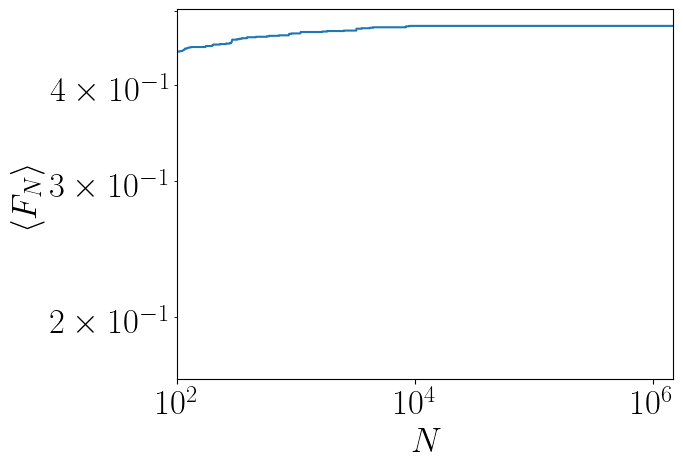

In [27]:
times = np.arange(1,Nvisits+1)

fig, ax = plt.subplots(1,1)

plt.plot(times, (mean_F))
# plt.plot(times, np.ones(times.size)*((2+mean_F) / ((np.log(np.log(times)))))[-1],'--k')
# plt.plot(times, sqrtfit(times,A))
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\langle F_N \rangle$")
plt.xlim(100,times[-1])
plt.loglog()

# plt.xlim(-2.5,4)
# plt.savefig(f"Figures/mean-nb-flips-boundary-to-origin-2d.pdf", dpi=600,bbox_inches='tight')
plt.show()

# 4d case

In [72]:
Nsamples = 75000
Nvisits = 15000
dir_array = np.array([[-1,0,0,0],[1,0,0,0],[0,1,0,0],[0,-1,0,0],[0,0,1,0],[0,0,-1,0],[0,0,0,1],[0,0,0,-1]])

@jit(nopython=True)
def flip_list_sample_origin():
    # here a flip happens when the RW goes from incrementing the span to the origin of the walk
    # returns an array flip_array of size Nvisits / sample_flip_gap 
    # flip[k] is 1 if there has been a flip at the sample_flip_gap * k visit, 0 else
    food_eaten = 1
    c0 = (0,0,0,0)
    c=c0
    pos={}
    pos[c]=True

    last_color_eaten = 1 # -1 = origin, 1 = boundary (positive >0 abscissa)
    flip_array = np.zeros(Nvisits) # flip_array[k] is 0 if no flip at the kth visit, 1 else
    while food_eaten <= Nvisits-1:
        v = dir_array[np.random.randint(0,8)]
        c=(c[0]+v[0],c[1]+v[1],c[2]+v[2],c[3]+v[3])
        is_c_0 = (c==c0)

        # only consider the event if either the walker is at the boundary, or if it transitions from the boundary to the origin
        # if (c not in pos) or (is_c_0 and (last_color_eaten==1)):
        #     color = 2*(1- is_c_0) - 1 # -1 at origin, 1 else
        #     flip = (color * last_color_eaten)<0
        #     # print(c,color)
        #     last_color_eaten = color
        #     flip_array[food_eaten] = flip
        #     if not (is_c_0):
        #           pos[c] = True
        #           food_eaten += 1

        if c not in pos:
            pos[c]=True
            # flip_array[food_eaten]=int(last_color_eaten==-1)
            food_eaten+=1
            last_color_eaten=1
            
        elif last_color_eaten==1 and is_c_0:
            flip_array[food_eaten]=1
            last_color_eaten=-1
            # food_eaten+=1 don't do it... useless and not what we want

        
    # print(nb_origin)
    return flip_array


In [73]:
f = []
for s in range(Nsamples):
    f.append(flip_list_sample_origin())
    if s % 1000==0:
        print(s)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000


In [74]:
f_mean = np.mean(f, axis=0)
mean_F = np.cumsum(f_mean)
np.save("./mean_F_4d.npy",mean_F)

C:\Users\julie\AppData\Local\Temp\ipykernel_10116\1797735572.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,3e3)


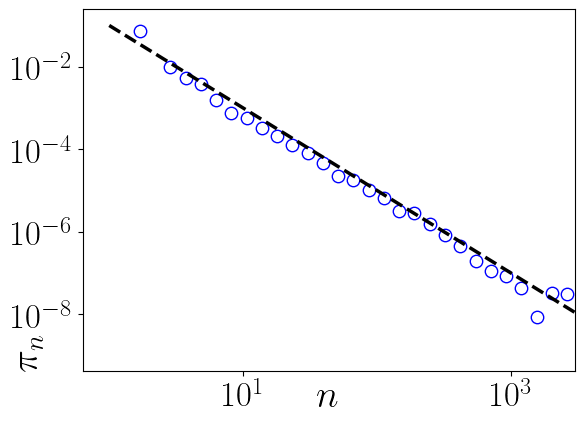

In [11]:

mean_F = np.load("./mean_F_4d.npy")
Nvisits=mean_F.size
mu = 4/2
base=1.3
t_logscale = np.array([base**i for i in range(0,int(np.emath.logn(base,Nvisits)))])
pi_coarsegrained = np.array([(mean_F[int(base**(i+1))]-mean_F[int(base**i)])/(base**(i)) for i in range(0,int(np.emath.logn(base,Nvisits)))])
fig, ax = plt.subplots(1, 1)
plt.scatter(
    t_logscale,
    pi_coarsegrained,
    color='blue',           # Edge color
    s=80,                    # Marker size (7^2)
    facecolors='white',      # Hollow markers
    linewidths=1             # Edge line width
)

plt.plot(t_logscale, .1/ (t_logscale**(mu)),'--k',linewidth=2.5)

# plt.plot(t_logscale, pi_coarsegrained * (t_logscale**(3-2/mu)),'--k',linewidth=2.5)

plt.semilogx()
plt.semilogy()
ax.set_xlim(0,3e3)

ax.set_ylabel(r'$\pi_n$', fontsize=28, labelpad=-25,loc='bottom')
ax.set_xlabel(r'$n$', fontsize=28, labelpad=-25,loc='center')
plt.tight_layout()
plt.savefig('./Figures/pin-4d.pdf', dpi=600, bbox_inches='tight')
plt.show()

# 5D case

In [2]:
Nsamples = 75000
Nvisits = 15000
dir_array = np.array([[-1,0,0,0,0],[1,0,0,0,0],[0,1,0,0,0],[0,-1,0,0,0],[0,0,1,0,0],[0,0,-1,0,0],[0,0,0,1,0],[0,0,0,-1,0],[0,0,0,0,-1],[0,0,0,0,1]])

@jit(nopython=True)
def flip_list_sample_origin():
    # here a flip happens when the RW goes from incrementing the span to the origin of the walk
    # returns an array flip_array of size Nvisits / sample_flip_gap 
    # flip[k] is 1 if there has been a flip at the sample_flip_gap * k visit, 0 else
    food_eaten = 1
    c0 = (0,0,0,0,0)
    c=c0
    pos={}
    pos[c]=True

    last_color_eaten = 1 # -1 = origin, 1 = boundary (positive >0 abscissa)
    flip_array = np.zeros(Nvisits) # flip_array[k] is 0 if no flip at the kth visit, 1 else
    while food_eaten <= Nvisits-1:
        v = dir_array[np.random.randint(0,10)]
        c=(c[0]+v[0],c[1]+v[1],c[2]+v[2],c[3]+v[3],c[4]+v[4])
        is_c_0 = (c==c0)

        # only consider the event if either the walker is at the boundary, or if it transitions from the boundary to the origin
        # if (c not in pos) or (is_c_0 and (last_color_eaten==1)):
        #     color = 2*(1- is_c_0) - 1 # -1 at origin, 1 else
        #     flip = (color * last_color_eaten)<0
        #     # print(c,color)
        #     last_color_eaten = color
        #     flip_array[food_eaten] = flip
        #     if not (is_c_0):
        #           pos[c] = True
        #           food_eaten += 1

        if c not in pos:
            pos[c]=True
            # flip_array[food_eaten]=int(last_color_eaten==-1)
            food_eaten+=1
            last_color_eaten=1
            
        elif last_color_eaten==1 and is_c_0:
            flip_array[food_eaten]=1
            last_color_eaten=-1
            # food_eaten+=1 don't do it... useless and not what we want

        
    # print(nb_origin)
    return flip_array


In [3]:
f = []
for s in range(Nsamples):
    f.append(flip_list_sample_origin())
    if s % 1000==0:
        print(s)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000


In [4]:
f_mean = np.mean(f, axis=0)
mean_F = np.cumsum(f_mean)
np.save("./mean_F_5d.npy",mean_F)

In [1]:

mean_F = np.load("./mean_F_5d.npy")
mu = 5/2
base=1.2
t_logscale = np.array([base**i for i in range(0,int(np.emath.logn(base,Nvisits)))])
pi_coarsegrained = np.array([(mean_F[int(base**(i+1))]-mean_F[int(base**i)])/(base**(i)) for i in range(0,int(np.emath.logn(base,Nvisits)))])
fig, ax = plt.subplots(1, 1)
plt.scatter(
    t_logscale,
    pi_coarsegrained,
    color='blue',           # Edge color
    s=80,                    # Marker size (7^2)
    facecolors='white',      # Hollow markers
    linewidths=1             # Edge line width
)

plt.plot(t_logscale, .06/ (t_logscale**(mu)),'--k',linewidth=2.5)
# plt.plot(t_logscale, .06/ (t_logscale**(3-2/mu)),'--',linewidth=2.5,color= 'red')

# plt.plot(t_logscale, pi_coarsegrained * (t_logscale**(mu)),'--k',linewidth=2.5)

plt.semilogx()
plt.semilogy()
ax.set_xlim(1,5e3)

ax.set_ylabel(r'$\pi_n$', fontsize=28, labelpad=-25,loc='bottom')
ax.set_xlabel(r'$n$', fontsize=28, labelpad=-25,loc='center')
plt.tight_layout()
# plt.savefig('./Figures/pin-5d.pdf', dpi=600, bbox_inches='tight')
plt.show()

NameError: name 'np' is not defined

# 1D check

In [22]:
f = []
for s in range(Nsamples):
    f.append(flip_list_sample_1d())
    print(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\julie\AppData\Local\Temp\ipykernel_25228\4023120022.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, (1+mean_F) / ((np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_25228\4023120022.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times, (1+mean_F) / ((np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_25228\4023120022.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, np.ones(times.size)*((1+mean_F) / ((np.log(times))))[-1],'--k')
C:\Users\julie\AppData\Local\Temp\ipykernel_25228\4023120022.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times, np.ones(times.size)*((1+mean_F) / ((np.log(times))))[-1],'--k')


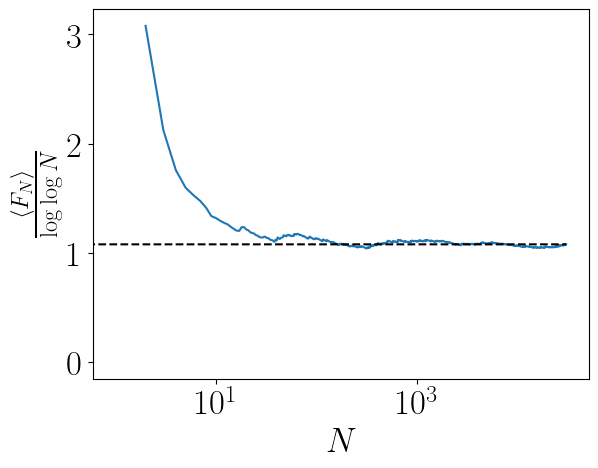

In [ ]:
## REFERENCE

mean_F = np.mean(np.cumsum(f,axis=1),axis=0  )
times = np.arange(Nvisits)

fig, ax = plt.subplots(1,1)

plt.plot(times, (1+mean_F) / ((np.log(times))))
plt.plot(times, np.ones(times.size)*((1+mean_F) / ((np.log(times))))[-1],'--k')
# plt.plot(times, sqrtfit(times,A))
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\frac{\langle F_N \rangle}{\log \log N}$")

plt.semilogx()

# plt.xlim(-2.5,4)
# plt.savefig(f"Figures/mean-nb-flips-boundary-to-origin-2d.pdf", dpi=600,bbox_inches='tight')
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_25228\952187113.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, (+mean_F) / ((np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_25228\952187113.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times, (+mean_F) / ((np.log(times))))
C:\Users\julie\AppData\Local\Temp\ipykernel_25228\952187113.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, np.ones(times.size)*((+mean_F) / ((np.log(times))))[-1],'--k')
C:\Users\julie\AppData\Local\Temp\ipykernel_25228\952187113.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times, np.ones(times.size)*((+mean_F) / ((np.log(times))))[-1],'--k')


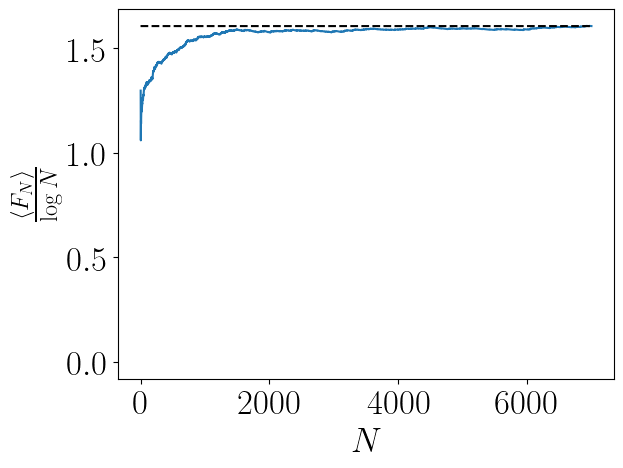

In [27]:
mean_F = np.mean(np.cumsum(f,axis=1),axis=0  )
times = np.arange(Nvisits)

fig, ax = plt.subplots(1,1)

plt.plot(times, (+mean_F) / ((np.log(times))))
plt.plot(times, np.ones(times.size)*((+mean_F) / ((np.log(times))))[-1],'--k')
# plt.plot(times, sqrtfit(times,A))
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\frac{\langle F_N \rangle}{\log N}$")

# plt.semilogx()

# plt.xlim(-2.5,4)
# plt.savefig(f"Figures/mean-nb-flips-boundary-to-origin-2d.pdf", dpi=600,bbox_inches='tight')
plt.show()